# Using Principal Component Analysis to classify handwritten digits
Gonna try to recreate my a simple machine learning (ML) model based of principal component analysis (PCA) to analyze the MNIST dataset and classify unlabelled images of digits. Just finished Linear Algebra and wanna apply one of the labs.

In [56]:
import idx2numpy
import numpy as np
import numpy.linalg as la

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as px
from plotly.subplots import make_subplots

plt.rcParams['figure.figsize'] = (6, 3)

Labels: [5 0 4 1 9]


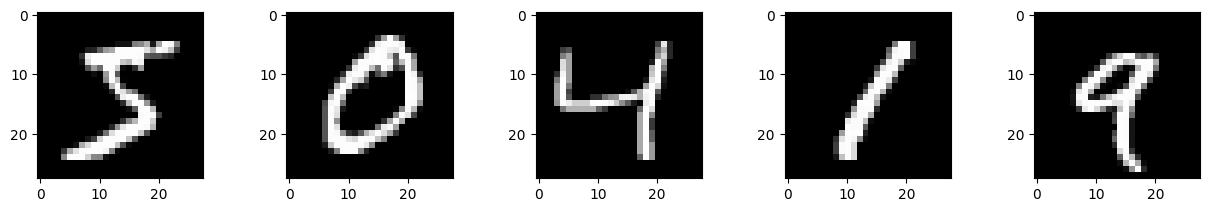

In [5]:
# (60000, 28, 28) images, (60000,) labels
images_2d = idx2numpy.convert_from_file("../data/train-images.idx3-ubyte")
# cover to 2D array (6000, 28 * 28 = 784)
images = images_2d.reshape(images_2d.shape[0], -1)
labels = idx2numpy.convert_from_file("../data/train-labels.idx1-ubyte")

images_shown = 5

print("Labels:", labels[:images_shown])

f, axes = plt.subplots(1, images_shown,
                      figsize=(images_shown * 3, 3),
                      gridspec_kw={'wspace': images_shown/10})
for i, ax in enumerate(axes):
    ax.imshow(images_2d[i], cmap="gray")

## Run PCA on the MNIST images

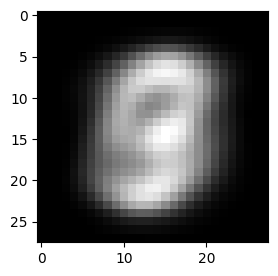

In [6]:
# We need to first center the images so each axias means is zero
# This returns the average image in a 28 x 28 array
mnist_avg = np.average(images, axis=0)
images_shifted = images - mnist_avg

plt.imshow(mnist_avg.reshape((28, 28)), cmap='gray')

In [ ]:
# Now that we have the shifted images, we can compute the SVD
U, S, Vt = la.svd(images_shifted, full_matrices=False)
V = Vt.T

## Apply dimension reduction to PCA

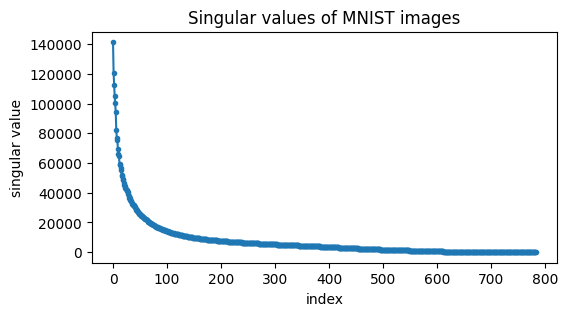

In [8]:
# In this plot we see how the singular values decay
# Showing how the first few singular values capture most of the variance
# These singular values apply a greater weighting to the corresponding singular vectors
plt.plot(S, '.-')
plt.xlabel('index')
plt.ylabel('singular value')
plt.title('Singular values of MNIST images')
plt.show()

(0.0, 50.0)

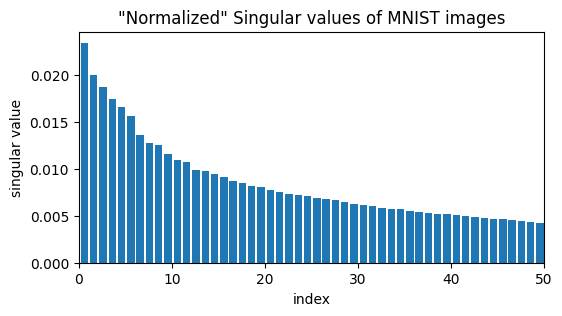

In [9]:
# Normalizing the singular values to show their relative importance
# We see the big difference even in the first 50 singular values
plt.bar(np.arange(len(S)) + .6, S/sum(S))
plt.xlabel('index')
plt.ylabel('singular value')
plt.title('"Normalized" Singular values of MNIST images')
plt.xlim(0,50)

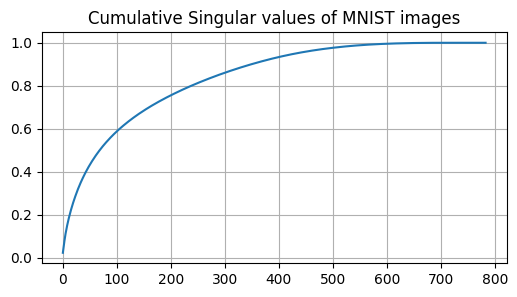

In [10]:
# cum_var is the cumulative sum of the normalized singular values
# Basically the cumulative explained variance - showing how much of the total information is captured as you include more singular values
S_norm = S / np.sum(S)
cum_var = np.cumsum(S_norm)

# This plot shows as we add more singular values, how much of the total variance is captured
# We see how the first 100 singular values capture 60% of the total variance
plt.plot(range(len(S)), cum_var)
plt.title('Cumulative Singular values of MNIST images')
plt.grid()

(0.0, 20.0)

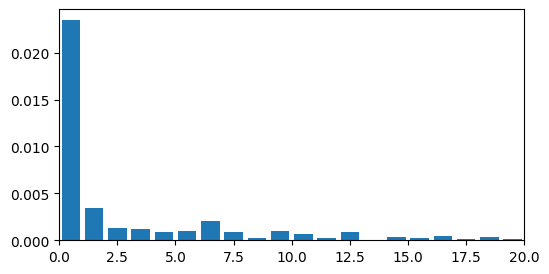

In [11]:
# To find the "kink" in the singular values, we can look for the point where the difference between consecutive singular values increases
# In essence, you want to find the earliest singular value which marks an increased difference from the previous one
# Generally, the (absolute) difference between consecutive singular values should decrease, so identifying the earliest *increase* in these differences will capture any kinks
# like the one we see in the above plot

# This is an array of the difference between consecutive singular values
S_diff = np.append(S_norm[0], np.abs(S_norm[1:] - S_norm[:-1]))
plt.bar(np.arange(len(S)) + .5, S_diff)
plt.xlim(0,20)

In [12]:
# The algorithm is looking for when the rate of decay starts to become irregular
# In a clean exponential decay, each difference should be smaller than the previous one
# But when we hit the "elbow" the singular values stop getting consistently smaller
# And the gaps between them stop getting consistently smaller
# This indicates we've moved past the "important" singular values into the "noise" region

# argmax returns the index of the first occurrence of the maximum value or first true value
reduced_demension = np.argmax(S_diff[1:] - S_diff[:-1] > 0) + 1
# So we cut down from 784 to 5 dimensions
reduced_V = V[:, :reduced_demension]
print(reduced_demension)

5


### Building a nearest-neighbor classifier on MNIST

In [ ]:
# Now that we use PCA to reduce the dimensionality of the images, we can project the original images onto the reduced space
# This next part is a simple machine learning algorithm which is K-Nearest Neighbors (KNN)

# Found it weird why we do this order but (n_samples, n_features) @ (n_features, n_components) = (n_samples, n_components)
# This is the projection of the original images onto the reduced principle components space
images_projected = images @ reduced_V

Labels: [7 2 1 0 4]


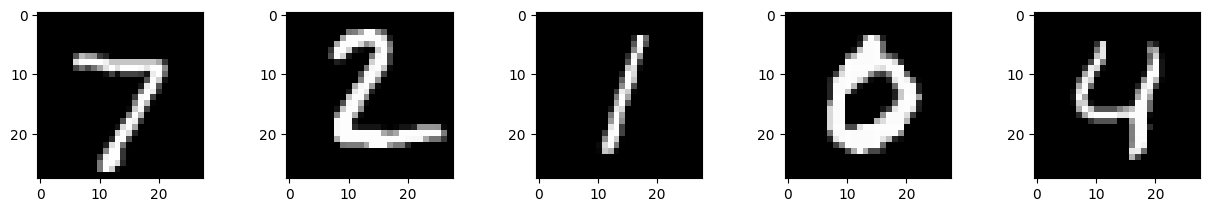

In [107]:
test_images_2d = idx2numpy.convert_from_file("../data/t10k-images.idx3-ubyte")
test_images = test_images_2d.reshape(test_images_2d.shape[0], -1)
test_labels = idx2numpy.convert_from_file("../data/t10k-labels.idx1-ubyte")

test_images_shown = 5

print("Labels:", test_labels[:test_images_shown])

f, axes = plt.subplots(
    1,
    test_images_shown,
    figsize=(test_images_shown * 3, 3),
    gridspec_kw={"wspace": test_images_shown / 10},
)
for i, ax in enumerate(axes):
    ax.imshow(test_images_2d[i], cmap="gray")

In [15]:
image_index = 0
test_projection = (test_images[image_index] - mnist_avg) @ reduced_V
distances = np.linalg.norm(images_projected - test_projection, axis=1)
n = np.argmin(distances)
print(n)

11400


Label: 7


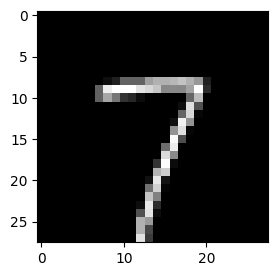

In [16]:
print("Label:", labels[n])
plt.imshow(images[n].reshape((28, 28)), cmap="gray");

### Checks results

In [ ]:
test_images_centered = test_images - mnist_avg
test_projections = test_images_centered @ reduced_V

In [18]:
correct_count = 0

for i in range(test_images.shape[0]):
    distances = np.linalg.norm(images_projected - test_projections[i], axis=1)
    n = np.argmin(distances)
    if labels[n] == test_labels[i]:
        correct_count += 1

print(f"Correct Count:{correct_count}")
print(f"Total Test Images:{test_images.shape[0]}")
print(f"Accuracy: {correct_count / test_images.shape[0] * 100:.2f}%")

Correct Count:4495
Total Test Images:10000
Accuracy: 44.95%


## Testing Ideas

### Finding best dimensionality

In [ ]:
def dimension_number_classification_accuracy(
    dimensions=reduced_demension, max_train_images=test_images.shape[0]
):
    reduced_V = V[:, :dimensions]
    images_projected = images @ reduced_V
    test_images_centered = test_images - mnist_avg
    test_projections = test_images_centered @ reduced_V

    correct_count = 0

    for i in range(max_train_images):
        distances = np.linalg.norm(images_projected - test_projections[i], axis=1)
        n = np.argmin(distances)
        if labels[n] == test_labels[i]:
            correct_count += 1
            
    accuracy = correct_count / max_train_images * 100
    return accuracy, correct_count, max_train_images

In [24]:
results_data_dim = []
dimensions = [1, 3, reduced_demension, 10, 15, 25, 50, 100]
for dimension in dimensions:
    accuracy, correct, total = dimension_number_classification_accuracy(dimension, 1000)
    results_data_dim.append(
        {
            "Dim": dimension,
            "Accuracy (%)": accuracy,
            "Correct": f"{correct}/{total}",
        }
    )

df_for_dim = pd.DataFrame(results_data_dim)
display(df_for_dim.style.hide(axis="index").format({"Accuracy (%)": "{:.2f}"}))

Dim,Accuracy (%),Correct
1,17.50,175/1000
3,30.50,305/1000
5,42.80,428/1000
10,62.30,623/1000
15,71.70,717/1000
25,80.30,803/1000
50,84.20,842/1000
100,84.80,848/1000


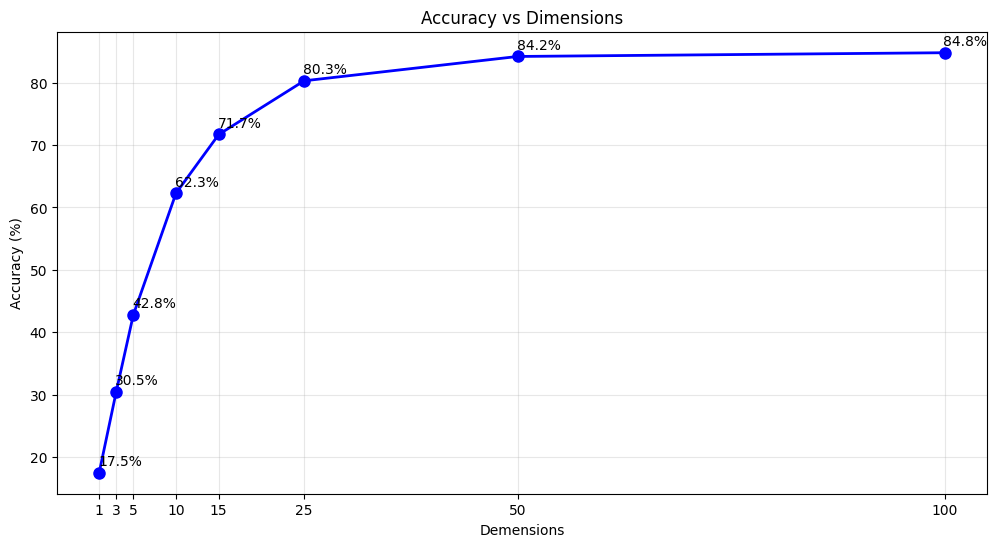

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(
    dimensions, df_for_dim["Accuracy (%)"].values, "bo-", linewidth=2, markersize=8
)
plt.xlabel("Demensions")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Dimensions")
plt.grid(True, alpha=0.3)
plt.xticks(dimensions)
for k, acc in zip(dimensions, df_for_dim["Accuracy (%)"].values):
    plt.annotate(
        f"{acc:.1f}%", (k, acc), textcoords="offset points", xytext=(15, 5), ha="center"
    )
plt.show()

The more dimension I add the better accuracy becomes. Though it does get to a point of diminishing returns. Though going back to previous image where we saw 60% of info is in the first 100 dimension this seems right. Though the "kink" we found at 5 was able to get a good  performance for the tradeof of accuracy.

### Apply proper KNN (K Nearest Neighbors)

In [ ]:
# Odd K values can help avoid ties
# Small k values can be more sensitive to noise but captures local patterns
# Larger k values can smooth out the decision boundary but lose details
# I've seen that sqrt(k) is a common heuristic for choosing k

def knn_number_classification_accuracy(
    dimensions=reduced_demension, k=1, max_train_images=test_images.shape[0]
):
    reduced_V = V[:, :dimensions]
    images_projected = images @ reduced_V
    test_images_centered = test_images - mnist_avg
    test_projections = test_images_centered @ reduced_V

    correct_count = 0

    for i in range(max_train_images):
        distances = np.linalg.norm(images_projected - test_projections[i], axis=1)
        # Split around pivot but doesn't care about order within the half
        k_nearest_indices = np.argpartition(distances, k)[:k]
        k_nearest_labels = labels[k_nearest_indices]
        # Array with indice showing count of each label
        counts = np.bincount(k_nearest_labels)
        most_repeated_number = np.argmax(counts)
        if most_repeated_number == test_labels[i]:
            correct_count += 1

    accuracy = correct_count / max_train_images * 100
    return accuracy, correct_count, max_train_images

In [20]:
results_data_k_val = []
k_vals = [1, 3, 5, 7, 9, 13, 17, 21, 27]
for k_val in k_vals:
    accuracy, correct, total = knn_number_classification_accuracy(reduced_demension, k_val, 1000)
    results_data_k_val.append(
        {"k": k_val, "Accuracy (%)": accuracy, "Correct": f"{correct}/{total}"}
    )

df_for_k_vals = pd.DataFrame(results_data_k_val)
display(df_for_k_vals.style.hide(axis="index").format({"Accuracy (%)": "{:.2f}"}))

k,Accuracy (%),Correct
1,42.80,428/1000
3,42.40,424/1000
5,41.70,417/1000
7,41.00,410/1000
9,41.10,411/1000
13,41.40,414/1000
17,41.30,413/1000
21,42.50,425/1000
27,41.60,416/1000


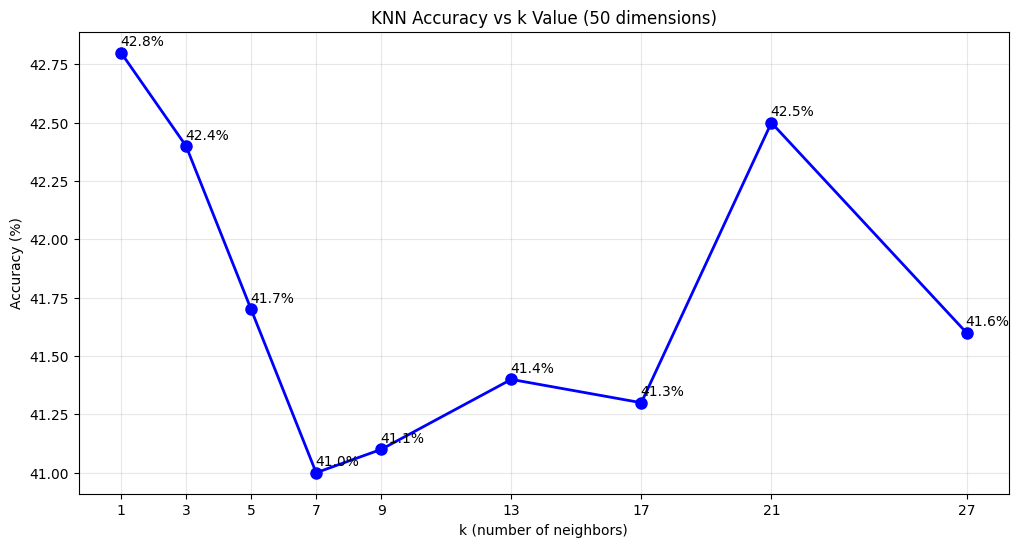

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(k_vals, df_for_k_vals["Accuracy (%)"].values, "bo-", linewidth=2, markersize=8)
plt.xlabel("k (number of neighbors)")
plt.ylabel("Accuracy (%)")
plt.title("KNN Accuracy vs k Value (50 dimensions)")
plt.grid(True, alpha=0.3)
plt.xticks(k_vals)
for k, acc in zip(k_vals, df_for_k_vals["Accuracy (%)"].values):
    plt.annotate(
        f"{acc:.1f}%", (k, acc), textcoords="offset points", xytext=(15, 5), ha="center"
    )
plt.show()

MNIST has high dineionality and the images are very simple where there isn't too much noise and local patterns at a smaller k might be better than having greater k values.

### Switch to a more curve based coordinate system

Just a crazy I had. Basically seeing how frequency could be better moddeled using the DCT coordinate space which is also used for JPEG compression. Maybe by changing to a different coordinate system and then applying SVD to find the orthogonal eigenvectors of this new curve space might be better to preserve more of the curves of the tougher numbers???

There are multiply frequency-domain transforms I've seen. So far I'll try DCT and Fourier.

In [32]:
results_per_num = {
    i: {"Num": i, "Correct": 0, "Total": 0, "Accuracy (%)": 0} for i in range(10)
}

for i in range(test_images.shape[0]):
    distances = np.linalg.norm(images_projected - test_projections[i], axis=1)
    n = np.argmin(distances)
    if labels[n] == test_labels[i]:
        results_per_num[test_labels[i]]["Correct"] += 1
    results_per_num[test_labels[i]]["Total"] += 1

for i in range(10):
    results_per_num[i]["Accuracy (%)"] = (
        results_per_num[i]["Correct"] / results_per_num[i]["Total"] * 100
    )

df_per_num = pd.DataFrame.from_dict(results_per_num, orient="index")

print(f"Total Correct: {df_per_num["Correct"].values.sum()}")
print(f"Total Tests: {df_per_num["Total"].values.sum()}", )
print(
    f"Total Accuracy: {df_per_num['Correct'].values.sum() / df_per_num['Total'].values.sum() * 100:.2f}%"
)
df_per_num_ordered = df_per_num.sort_values(by="Accuracy (%)", ascending=False)
display(df_per_num_ordered.style.hide(axis="index").format({"Accuracy (%)": "{:.2f}"}))

Total Correct: 4495
Total Tests: 10000
Total Accuracy: 44.95%


Num,Correct,Total,Accuracy (%)
1,1129,1135,99.47
0,727,980,74.18
7,726,1028,70.62
3,568,1010,56.24
2,542,1032,52.52
6,268,958,27.97
5,247,892,27.69
4,174,982,17.72
9,76,1009,7.53
8,38,974,3.90


In [34]:
def dimension_number_classification_accuracy(
    dimensions=reduced_demension, max_train_images=test_images.shape[0]
):
    reduced_V = V[:, :dimensions]
    images_projected = images @ reduced_V
    test_images_centered = test_images - mnist_avg
    test_projections = test_images_centered @ reduced_V

    results_per_num = {
        i: {"Num": i, "Correct": 0, "Total": 0, "Accuracy (%)": 0} for i in range(10)
    }

    for i in range(max_train_images):
        distances = np.linalg.norm(images_projected - test_projections[i], axis=1)
        n = np.argmin(distances)
        if labels[n] == test_labels[i]:
            results_per_num[test_labels[i]]["Correct"] += 1
        results_per_num[test_labels[i]]["Total"] += 1

    for i in range(10):
        results_per_num[i]["Accuracy (%)"] = (
            results_per_num[i]["Correct"] / results_per_num[i]["Total"] * 100
        )

    df_per_num = pd.DataFrame.from_dict(results_per_num, orient="index")

    return df_per_num

dimensions = [1, 3, reduced_demension, 10, 15, 25, 50, 100]
pd_dimension_vs_accuracy = pd.DataFrame(data={"Num": np.arange(10)})

for dimension in dimensions:
    df_per_num = dimension_number_classification_accuracy(dimension, 1000)
    pd_dimension_vs_accuracy[dimension] = df_per_num["Accuracy (%)"]

display(
    pd_dimension_vs_accuracy.style.hide(axis="index").format(
        {col: "{:.2f}" for col in pd_dimension_vs_accuracy.columns if col != "Num"}
    )
)

Num,1,3,5,10,15,25,50,100
0,7.06,15.29,64.71,81.18,92.94,95.29,96.47,96.47
1,100.00,93.65,99.21,100.00,100.00,99.21,99.21,99.21
2,3.45,26.72,43.97,50.00,62.93,63.79,72.41,71.55
3,1.87,51.40,57.01,73.83,76.64,84.11,84.11,86.92
4,6.36,8.18,22.73,65.45,80.91,84.55,85.45,89.09
5,8.05,3.45,19.54,74.71,78.16,86.21,89.66,88.51
6,5.75,6.90,20.69,62.07,74.71,89.66,95.40,94.25
7,6.06,62.63,63.64,65.66,75.76,86.87,88.89,88.89
8,6.74,4.49,4.49,11.24,22.47,41.57,51.69,53.93
9,6.38,4.26,9.57,26.60,42.55,68.09,76.60,76.60


Examples above show how the accuracy of number with curves like 8 and 9 are very low compared to other like 0 and 1. Even as you increase dimensions it never really gets better compared to other numbers.

In [80]:
# Get dimension columns (everything except 'Num')
dimension_cols = [col for col in pd_dimension_vs_accuracy.columns if col != "Num"]

fig = make_subplots(rows=2, cols=4, subplot_titles=[str(col) for col in dimension_cols])

for i, dim_col in enumerate(dimension_cols):
    row = (i // 4) + 1
    col = (i % 4) + 1

    fig.add_trace(
        px.Bar(
            x=pd_dimension_vs_accuracy["Num"].tolist(),
            y=pd_dimension_vs_accuracy[dim_col].tolist(),
            showlegend=False,
        ),
        row=row,
        col=col,
    )

fig.update_yaxes(
    range=[0, 100],  # Force 0-100 range
    tickmode="array",  # Use specific tick values
    tickvals=[50, 100],  # Only show 0, 50, 100
    ticktext=["50", "100"],  # Labels for ticks
)


fig.update_layout(height=500, title_text="Accuracy by Digit Across Dimensions")
fig.show()

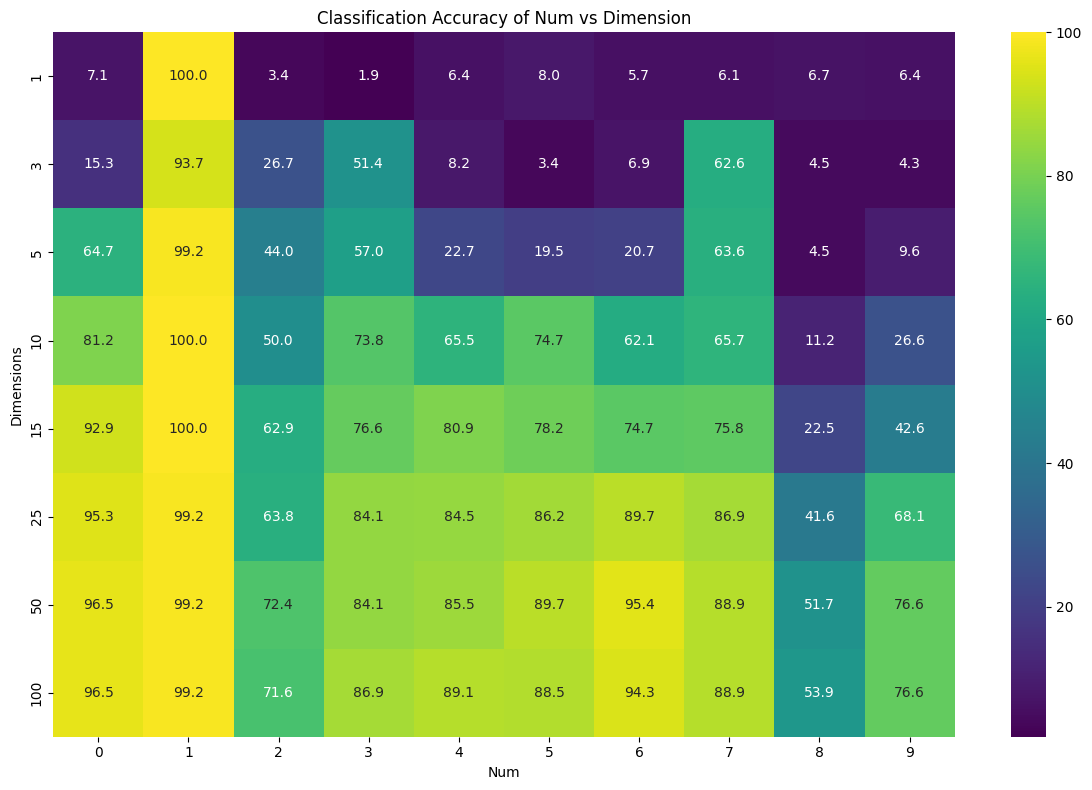

In [78]:
# Assuming your DataFrame has "Num" column and dimension columns
data_for_heatmap = pd_dimension_vs_accuracy.set_index(
    "Num"
).T  # Transpose to get dimensions as rows

plt.figure(figsize=(12, 8))
sns.heatmap(
    data_for_heatmap,
    annot=True,
    fmt=".1f",
    cmap="viridis",
    xticklabels=[f"{i}" for i in range(10)],
    yticklabels=data_for_heatmap.index,
)
plt.title("Classification Accuracy of Num vs Dimension")
plt.xlabel("Num")
plt.ylabel("Dimensions")
plt.tight_layout()
plt.show()

In [77]:
# Create mesh data
digits = pd_dimension_vs_accuracy["Num"].tolist()
dimensions = [int((f"{col}").replace("D", "")) for col in dimension_cols]
z_data = []

for dim_col in dimension_cols:
    z_data.append(pd_dimension_vs_accuracy[dim_col].tolist())

fig = px.Figure(
    data=[
        px.Surface(
            x=digits, y=dimensions, z=z_data, colorscale="Viridis", showscale=True
        )
    ]
)

fig.update_layout(
    title="3D Accuracy Surface",
    scene=dict(
        xaxis_title="Digit", yaxis_title="Dimensions", zaxis_title="Accuracy (%)"
    ),
    height=600,
)
fig.show()

Just wanted to try plotting some different types of graphes. Once I reallized I had 3 variables had to plot either heatmap or 3d.

#### DCT

Discrete cosine transform (DCT), which converts data into a linear combination of cosine waves.  When constructing the DCT matrix ${\bf D}$, the $i$'th entry (row) of the $k$'th basis vector (column) is thus given by: $$ D_{i, k} = \cos\left(\frac{\pi}{N} \left(i + \frac{1}{2}\right)k\right) $$
We also need to make sure each one is a basis vector at the end.

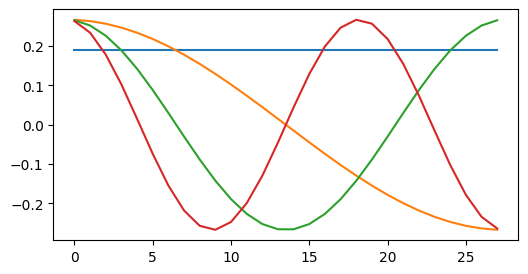

In [84]:
# Since DCT is usual used for 2d images it's prob better to keep it in 2D
DCT_basis = np.zeros((28, 28))

for i in range(28):
    for k in range(28):
        DCT_basis[i, k] = np.cos(np.pi / 28 * (i + 0.5) * k)

for k in range(28):
    norm = la.norm(DCT_basis[:, k])
    DCT_basis[:, k] = DCT_basis[:, k] / norm

plt.plot(DCT_basis[:, :4])

Excluding the horizontal line, each basis function is a cosine wave with period $2N/k$.

(60000, 28, 28)


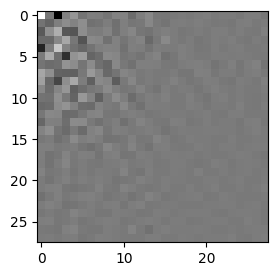

In [97]:
dct_images_2d = np.array([DCT_basis.T @ image_2d @ DCT_basis for image_2d in images_2d])
dct_images = dct_images_2d.reshape(dct_images_2d.shape[0], -1)
print(dct_images_2d.shape)
plt.imshow(dct_images_2d[0], cmap="gray")

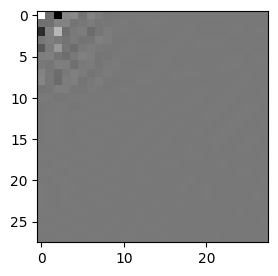

In [99]:
dct_mnist_avg = np.average(dct_images, axis=0)
dct_images_shifted = dct_images - dct_mnist_avg
plt.imshow(dct_mnist_avg.reshape((28, 28)), cmap="gray")

In [122]:
dct_U, dct_S, dct_Vt = la.svd(dct_images_shifted, full_matrices=False)
dct_V = dct_Vt.T

In [123]:
dct_S_norm = dct_S / np.sum(dct_S)
dct_S_diff = np.append(dct_S_norm[0], np.abs(dct_S_norm[1:] - dct_S_norm[:-1]))
dct_reduced_demension = np.argmax(dct_S_diff[1:] - dct_S_diff[:-1] > 0) + 1
dct_reduced_V = dct_V[:, :dct_reduced_demension]
dct_images_projected = dct_images_shifted @ dct_reduced_V
print(dct_reduced_demension)

5


Labels: [7 2 1 0 4]


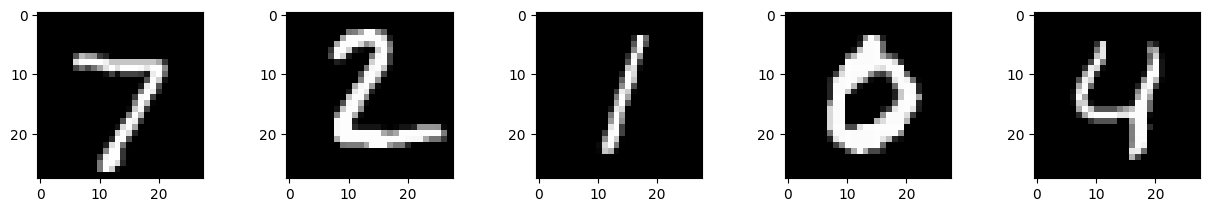

In [126]:
dct_test_images_2d = np.array(
    [DCT_basis.T @ test_image_2d @ DCT_basis for test_image_2d in test_images_2d]
)
dct_test_images = dct_test_images_2d.reshape(dct_test_images_2d.shape[0], -1)

test_images_shown = 5

print("Labels:", test_labels[:test_images_shown])

f, axes = plt.subplots(
    1,
    test_images_shown,
    figsize=(test_images_shown * 3, 3),
    gridspec_kw={"wspace": test_images_shown / 10},
)
for i, ax in enumerate(axes):
    ax.imshow(test_images_2d[i], cmap="gray")

44622
Label: 1


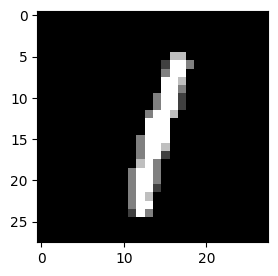

In [127]:
dct_image_index = 5

dct_test_projection = (dct_test_images[dct_image_index] - dct_mnist_avg) @ dct_reduced_V
distances = np.linalg.norm(dct_images_projected - dct_test_projection, axis=1)
n = np.argmin(distances)
print(n)
print("Label:", labels[n])
plt.imshow(images[n].reshape((28, 28)), cmap="gray")